In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from PIL import Image
import os
import cv2
import random
import shutil
import glob
from math import cos, sin, pi

from tqdm import tqdm
import tensorflow as tf
from keras.layers.advanced_activations import LeakyReLU, PReLU
from tensorflow.keras import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Activation, Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Conv2D, ZeroPadding2D, GlobalAveragePooling2D
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
#폴더 경로를 설정해줍니다.
os.chdir('./1. open') 

In [3]:
# 해당 코드는 아래 Train, Valid Split 이후에 실행
train = pd.read_csv('./train.csv')
valid = pd.read_csv('./valid.csv')

train_paths = glob.glob('./train/*.jpg')
valid_paths = glob.glob('./valid/*.jpg')
test_paths = glob.glob('./test_imgs/*.jpg')
print(len(train_paths), len(valid_paths), len(test_paths))

train_paths.sort()
valid_paths.sort()
test_paths.sort()

train['path'] = train_paths
valid['path'] = valid_paths

3776 419 1600


(1920, 1080)
(1920, 1080)
(1920, 1080)
(1920, 1080)
(1920, 1080)


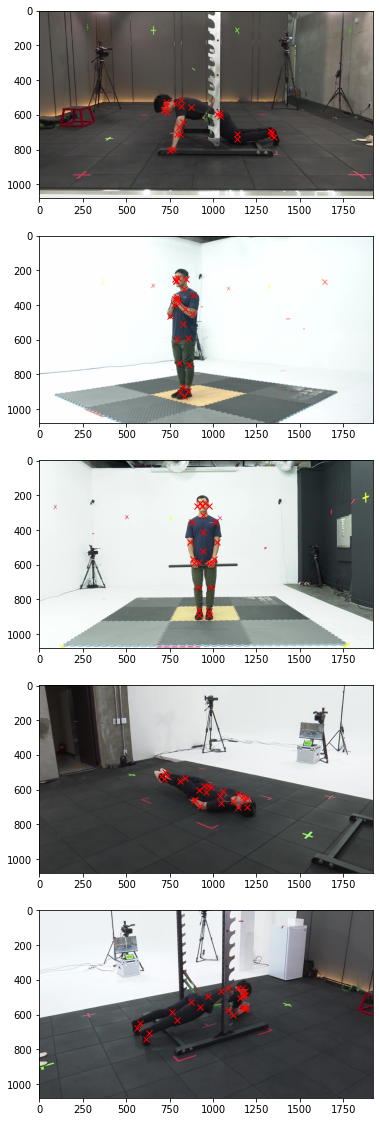

In [4]:
plt.figure(figsize=(40,20))
count=1

for i in np.random.randint(0,len(train_paths),5):
    
    plt.subplot(5,1, count)
    
    img_sample_path = train_paths[i]
    img = Image.open(img_sample_path)
    print(img.size)
    img_np = np.array(img)

    keypoint = train.iloc[:,1:49] #위치키포인트 하나씩 확인
    keypoint_sample = keypoint.iloc[i, :]
    
    for j in range(0,len(keypoint.columns),2):
        plt.plot(keypoint_sample[j], keypoint_sample[j+1],'rx')
        plt.imshow(img_np)
    
    count += 1

## Augmentation

In [5]:
pixel_shifts = [12]
rotation_angles = [12]
inc_brightness_ratio = 1.2
dec_brightness_ratio = 0.8
noise_ratio = 0.008

In [33]:
# 좌우 반전
def left_right_flip(images, keypoints):
    flipped_keypoints = []
    flipped_images = np.flip(images, axis=1)
    for idx, sample_keypoints in enumerate(keypoints):
        if idx%2 == 0:
            flipped_keypoints.append(480.-sample_keypoints)
        else:
            flipped_keypoints.append(sample_keypoints)
    
    # left_right_keypoints_convert
    for i in range(8):
        flipped_keypoints[2+(4*i):4+(4*i)], flipped_keypoints[4+(4*i):6+(4*i)] = flipped_keypoints[4+(4*i):6+(4*i)], flipped_keypoints[2+(4*i):4+(4*i)]
    flipped_keypoints[36:38], flipped_keypoints[38:40] = flipped_keypoints[38:40], flipped_keypoints[36:38]
    flipped_keypoints[44:46], flipped_keypoints[46:48] = flipped_keypoints[46:48], flipped_keypoints[44:46]
    
    return flipped_images, flipped_keypoints

In [34]:
# 수직/수평 동시 이동
# forloop에서 shift_x, shift_y 중 하나만 놓으면
# 수직 또는 수평 이동만 따로 시행 가능
def shift_images(images, keypoints):
    # tensor -> numpy
    images = images.numpy()
    shifted_images = []
    shifted_keypoints = []
    for shift in pixel_shifts:   
        for (shift_x,shift_y) in [(-shift,-shift),(-shift,shift),(shift,-shift),(shift,shift)]:
            # 이동할 matrix 생성
            M = np.float32([[1,0,shift_x],[0,1,shift_y]])
            shifted_keypoint = np.array([])
            shifted_x_list = np.array([])
            shifted_y_list = np.array([])
            # 이미지 이동
            shifted_image = cv2.warpAffine(images, M, (480,270), flags=cv2.INTER_CUBIC)
            # 이동한만큼 keypoint 수정
            for idx, point in enumerate(keypoints):
                if idx%2 == 0: 
                    shifted_keypoint = np.append(shifted_keypoint, point+shift_x)
                    shifted_x_list = np.append(shifted_x_list, point+shift_x)
                else: 
                    shifted_keypoint =np.append(shifted_keypoint, point+shift_y)
                    shifted_y_list = np.append(shifted_y_list, point+shift_y)
            # 수정된 keypoint가 이미지 사이즈를 벗어나지 않으면 append
            if np.all(0.0<shifted_x_list) and np.all(shifted_x_list<480) and np.all(0.0<shifted_y_list) and np.all(shifted_y_list<270):
                shifted_images.append(shifted_image.reshape(270,480,3))
                shifted_keypoints.append(shifted_keypoint)

    return shifted_images, shifted_keypoints

In [35]:
# 이미지 회전
def rotate_augmentation(images, keypoints):
    # tensor -> numpy
    images = images.numpy()
    rotated_images = []
    rotated_keypoints = []
    
    for angle in rotation_angles:
        for angle in [angle,-angle]:
            # 회전할 matrix 생성
            M = cv2.getRotationMatrix2D((240,135), angle, 1.0)
            # cv2_imshow로는 문제없지만 추후 plt.imshow로 사진을 확인할 경우 black screen 생성...
            # 혹시 몰라 matrix를 ndarray로 변환
            M = np.array(M, dtype=np.float32)
            angle_rad = -angle*pi/180
            rotated_image = cv2.warpAffine(images, M, (480,270))
            rotated_images.append(rotated_image)
            
            # keypoint를 copy하여 forloop상에서 값이 계속 없데이트 되는 것을 회피
            rotated_keypoint = keypoints.copy()
            rotated_keypoint[0::2] = rotated_keypoint[0::2] - 240
            rotated_keypoint[1::2] = rotated_keypoint[1::2] - 135
            
            for idx in range(0,len(rotated_keypoint),2):
                rotated_keypoint[idx] = rotated_keypoint[idx]*cos(angle_rad)-rotated_keypoint[idx+1]*sin(angle_rad)
                rotated_keypoint[idx+1] = rotated_keypoint[idx]*sin(angle_rad)+rotated_keypoint[idx+1]*cos(angle_rad)

            rotated_keypoint[0::2] = rotated_keypoint[0::2] + 240
            rotated_keypoint[1::2] = rotated_keypoint[1::2] + 135
            rotated_keypoints.append(rotated_keypoint)
        
    return rotated_images, rotated_keypoints

In [36]:
# 이미지 해상도 조절
def alter_brightness(images):
    altered_brightness_images = []
    inc_brightness_images = np.clip(images*inc_brightness_ratio, 0.0, 1.0)
    dec_brightness_images = np.clip(images*dec_brightness_ratio, 0.0, 1.0)
    altered_brightness_images.append(inc_brightness_images)
    altered_brightness_images.append(dec_brightness_images)
    return altered_brightness_images

In [37]:
# Random 노이즈 추가
def add_noise(images):
    images = images.numpy()
    noise = noise_ratio * np.random.randn(270,480,3)
    noise = noise.astype(np.float32)
    # 생성한 noise를 원본에 add
    noisy_image = cv2.add(images, noise)
    return noisy_image

## Aug 시각화 검증

1
2
3
4


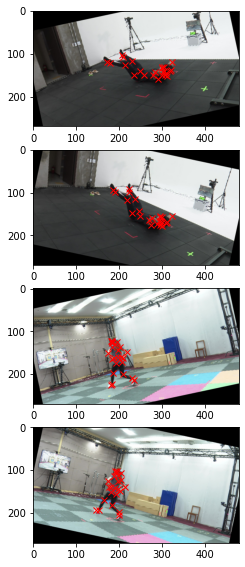

In [43]:
# shift & rotate
plt.figure(figsize=(40,20))
count=1

for i in np.random.randint(0, len(train), 2):
    
    img = tf.io.read_file(train['path'][i])
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [270,480])
    img = img/255
    target = train.iloc[:,1:49].iloc[i,:]
    target = target/4
    
    #img_list, target_list = shift_images(img, target)
    img_list, target_list = rotate_augmentation(img, target)

    for img_path, aug_target in zip(img_list, target_list):
        
        plt.subplot(8,1, count)
        img_np = np.array(img_path)

        for j in range(0,len(aug_target),2):
            plt.plot(aug_target[j], aug_target[j+1],'rx')
            plt.imshow(img_np)
            
        print(count)
        count += 1

1
2


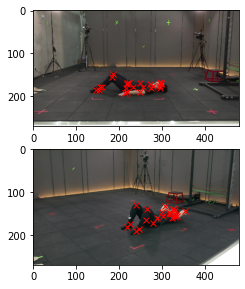

In [49]:
# flip
plt.figure(figsize=(40,20))
count=1

for i in np.random.randint(0, len(train), 2):

    img = tf.io.read_file(train['path'][i])
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [270,480])
    img = img/255
    target = train.iloc[:,1:49].iloc[i,:]
    target = target/4

    img_list, target_list = left_right_flip(img, target)

    plt.subplot(8,1, count)
    img_np = np.array(img_list)

    for j in range(0,len(target_list),2):
        plt.plot(target_list[j], target_list[j+1],'rx')
        plt.imshow(img_np)

    print(count)
    count += 1

## Generator

In [52]:
def trainGenerator():
    # 원본 이미지 resize
    for i in range(len(train)):
        img = Image.open(train['path'][i])  # path(경로)를 통해 이미지 읽기
        img = img.resize([480, 270])  # 이미지 resize
        img = np.array(img)  # 넘파이 배열로 변환
        img = img/255                         # 이미지 rescaling
        target = train.iloc[:,1:49].iloc[i,:] # keypoint 뽑아주기
        target = target/4                     # image size를 1920x1080 -> 480x270으로 바꿔줬으므로 keypoint도 변경

        yield (img, target)
    
    # horizontal flip
    for i in range(len(train)):
        img = Image.open(train['path'][i])  # path(경로)를 통해 이미지 읽기
        img = img.resize([480, 270])  # 이미지 resize
        img = np.array(img)  # 넘파이 배열로 변환
        img = img/255   
        target = train.iloc[:,1:49].iloc[i,:] 
        target = target/4
        img, target = left_right_flip(img, target)
        
        yield (img, target)

    # Horizontal & Vertical shift
    for i in range(len(train)):
        img = Image.open(train['path'][i])  # path(경로)를 통해 이미지 읽기
        img = img.resize([480, 270])  # 이미지 resize
        img = np.array(img)  # 넘파이 배열로 변환
        img = img/255   
        target = train.iloc[:,1:49].iloc[i,:]
        target = target/4
        img_list, target_list = shift_images(img, target)
        for shifted_img, shifted_target in zip(img_list, target_list):
            
            yield (shifted_img, shifted_target)

    # Rotation
    for i in range(len(train)):
        img = Image.open(train['path'][i])  # path(경로)를 통해 이미지 읽기
        img = img.resize([480, 270])  # 이미지 resize
        img = np.array(img)  # 넘파이 배열로 변환
        img = img/255   
        target = train.iloc[:,1:49].iloc[i,:]
        target = target/4
        img_list, target_list = rotate_augmentation(img, target)
        for rotated_img, rotated_target in zip(img_list, target_list):
            
            yield (rotated_img, rotated_target)

    # Alter_Brightness
    for i in range(len(train)):
        img = Image.open(train['path'][i])  # path(경로)를 통해 이미지 읽기
        img = img.resize([480, 270])  # 이미지 resize
        img = np.array(img)  # 넘파이 배열로 변환
        img = img/255   
        target = train.iloc[:,1:49].iloc[i,:]
        target = target/4
        img_list = alter_brightness(img)
        for altered_brightness_images in img_list:
            
            yield (altered_brightness_images, target)

    # Adding_Noise
    for i in range(len(train)):
        img = Image.open(train['path'][i])  # path(경로)를 통해 이미지 읽기
        img = img.resize([480, 270])  # 이미지 resize
        img = np.array(img)  # 넘파이 배열로 변환
        img = img/255   
        target = train.iloc[:,1:49].iloc[i,:]
        target = target/4
        noisy_img = add_noise(img)

        yield (noisy_img, target)

In [53]:
def validGenerator():
    # 원본 이미지 resize
    for i in range(len(valid)):
        img = tf.io.read_file(valid['path'][i]) # path(경로)를 통해 이미지 읽기
        img = tf.image.decode_jpeg(img, channels=3) # 경로를 통해 불러온 이미지를 tensor로 변환
        img = tf.image.resize(img, [270,480]) # 이미지 resize 
        img = img/255                         # 이미지 rescaling
        target = valid.iloc[:,1:49].iloc[i,:] # keypoint 뽑아주기
        target = target/4                     # image size를 1920x1080 -> 480x270으로 바꿔줬으므로 keypoint도 변경

        yield (img, target)

In [54]:
batch_size = 64

train_dataset = tf.data.Dataset.from_generator(trainGenerator, (tf.float32, tf.float32), (tf.TensorShape([270,480,3]),tf.TensorShape([48])))
train_dataset = train_dataset.batch(batch_size).prefetch(1)
valid_dataset = tf.data.Dataset.from_generator(validGenerator, (tf.float32, tf.float32), (tf.TensorShape([270,480,3]),tf.TensorShape([48])))
valid_dataset = valid_dataset.batch(batch_size).prefetch(1)

## Modeling

In [57]:
# Callback 설정
earlystop = EarlyStopping(patience=7)
learning_rate_reduction=ReduceLROnPlateau(
                        monitor= "val_loss", 
                        patience = 2, 
                        factor = 0.85, 
                        min_lr=1e-7,
                        verbose=1)

model_check = ModelCheckpoint( #에포크마다 현재 가중치를 저장    
        filepath='./model/{epoch:02d}-{val_mae:.4f}.hdf5', #모델 파일 경로
        monitor='val_loss',  # val_loss 가 좋아지지 않으면 모델 파일을 덮어쓰지 않음.
        save_best_only=True)

callbacks = [earlystop, learning_rate_reduction, model_check]

In [58]:
# Model Structure
model = Sequential()

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(270,480,3)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())


model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(48))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 270, 480, 32)      864       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 270, 480, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 270, 480, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 270, 480, 32)      9216      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 270, 480, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 270, 480, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 240, 32)      0

In [60]:
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='mean_squared_error',
              metrics=['mae'])

history = model.fit(train_dataset,
                    epochs=1000,
                    validation_data=valid_dataset,
                    callbacks = callbacks,
                    verbose=1)